The following tutorial introduces dynamic simulations (RMS/EMT), plotting and exporting of results (to pandas or csv) using *powfacpy*.

Let's again set up *PowerFactory* and create an instance of the class `PFPlotInterface`. This class inherits from `PFActiveProject` (so those methods are available). We use the '39-Bus New England' example from *PowerFactory* (see File->Examples).

In [1]:
import sys
sys.path.append(r'C:\Program Files\DIgSILENT\PowerFactory 2023 SP3\Python\3.11') # you may use a different directory
# Get the PF app
import powerfactory
app = powerfactory.GetApplication()
sys.path.insert(0,r'D:\User\seberlein\FraunhIEE-UniKassel-PowSysStability\powfacpy\src')
import powfacpy
app.Show()
app.ActivateProject(r"powfacpy\39-bus_new_engl_copy_where_tests_are_run") # You may change the project path. Make sure the path starts with "\"
pfpi = powfacpy.PFPlotInterface(app)
pfpi.activate_study_case(r"Study Cases\2.1 Simulation Fault Bus 16 Stable")

<powerfactory.DataObject <l1>\seberlein.IntUser\powfacpy\39-bus_new_engl_copy_where_tests_are_run.IntPrj\Study Cases.IntPrjfolder\2.1 Simulation Fault Bus 16 Stable.IntCase</l1>>

# Plotting inside *PowerFactory*

In *PowerFactory*, monitored result variables (to be later plotted or exported) need to be specified before the simulation. The easiest way to plot results using *powfacpy* is to simply use the method `plot` before the simulation, which automaticallly adds a variable to the monitored variables and plots it as soon as the simulation has run.

First, we set the active plot (starting from a clean graphics board by clearing all plot pages).

In [2]:
pfpi.clear_plot_pages() # Start from a clean graphics board
pfpi.set_active_plot("Plot 1", "Plot page 1")

The method `set_active_plot` takes the name of the plot and the name of the page of the plot as input arguments. If the plot (or the page) does not exist, it is created. If there should be several plots on one page, the method is called several times with the same page name but different plot name (e.g. `pfpi.set_active_plot("Plot 2", "Plot page 1")`). 

All plot commmands are applied to the active plot. We can now add curves to the plot.

In [3]:
# Curve of variable "s:P1"
pfpi.plot(r"Network Model\Network Data\Grid\G 01", "s:P1")

# Curve of variable "s:Q1"
g_01 = pfpi.get_unique_obj(r"Network Model\Network Data\Grid\G 01")
results_obj = pfpi.get_unique_obj(r"Study Cases\2.1 Simulation Fault Bus 16 Stable\All calculations")
# Plot with keyword arguments
pfpi.plot(g_01, # obj or str
    "s:Q1", 
    linestyle = 3, 
    linewidth = 200, 
    color = 5,
    label = "Reactive power setpoint",
    results_obj = results_obj)

The method `plot` takes the PF object (or its path) and a results variable as first and second input. Furthermore, keyword arguments can be specified as shown for the second curve. 

Now we can execute a dynamic simulation using the dynamic simulation interface class.

In [4]:
pfds = powfacpy.PFDynSimInterface(app)
pfds.initialize_sim({"iopt_sim": "rms"})
pfds.run_sim({"tstop": 0.5})

The two methods initialize and run the simulation. Paramters for the ComInc object (initialization) and the ComSim (run simulation) can be specified in a dictionary. If no parameters need to be set, one can also use:

In [5]:
pfds.initialize_and_run_sim()

In some cases, it might be more convenient to add the result variable first, then simulate and finally specifiy the plot:

In [6]:
pfpi.clear_curves()
pfds.initialize_sim({"iopt_sim": "rms"})
pfds.add_results_variable(g_01, "s:P1")
pfds.run_sim()
pfpi.plot_monitored_variables(g_01, "s:P1")

So the method `add_results_variable` is used to add variables to the monitored vaiables to later export or plot them.

*powfacpy* offers more functionality that are helpful in this context. The `ResVar` class offers enumeration subclasses for results variables of various simulation types (e.g. RMS balanced/unbalanced, EMT, load flow balanced/unbalanced). The names of *PowerFactory* result variables can be cryptic. The enumeration classes offer an easy way to get the names and document also their short description (just hover over `s_P1` in `RMS_bal.ElmSym.s_P1` in the cell below). Code completion in your IDE helps you find the variable you want without having to look it up in *PowerFactory*. The syntax is

`simulation_type`.`class_name`.`variable_name`.`value`

e.g.

- `RMS_bal.ElmSym.s_P1.value`
- `RMS_bal.ElmSym.m_Psum_bus1.value` .

In the variable name, colons (":") are replaced by underscores ("_") to comply with python naming restrictions. The `value` at the end is required to get the name string of the variable. It is assumed that you set `RMS_bal = ResVar.RMS_Bal` as in the cell below.


Additionally, `create_dyn_sim_event` in the cell below creates an event, here we add a parameter event. 

In [7]:
from powfacpy.result_variables import ResVar
RMS_bal = ResVar.RMS_Bal # we focus on balanced RMS simulation here

pfpi.clear_curves()
pfds.initialize_sim({"iopt_sim": "rms"})
pfds.add_results_variable(g_01, RMS_bal.ElmSym.s_P1.value)
pfds.create_dyn_sim_event("Set_turbine_power_of_g01.EvtParam", 
                          {"p_target": g_01, 
                           "variable": "pt", 
                           "value": "0.5",
                           "time": 0})
pfds.run_sim()
pfpi.plot_monitored_variables(g_01, RMS_bal.ElmSym.s_P1.value)

Sometimes we have created plots in one study case and want to have those plots also in another study case. This can be achieved by copying the graphics board content (or parts of it) from one study case to another:

In [8]:
study_case_1 = pfpi.get_unique_obj(
  r"Study Cases\2.1 Simulation Fault Bus 16 Stable")
study_case_2 = pfpi.get_unique_obj(
  r"Study Cases\2.2 Simulation Fault Bus 16 Unstable")
pfpi.copy_graphics_board_content(study_case_1, study_case_2, "*.GrpPage")

This copies all plot pages (class GrpPage) of Study Case 1 to Study Case 2. The target study case argument can also be a list of cases. Or we can use the method `copy_graphics_board_content_to_all_study_cases` to target all study cases or all cases in a certain folder.

# Getting Objects from the Initial Conditions Calculation (ComInc)
A common source of error is that users access objects from the active study case (e.g. results object (ElmRes)) which they assume to be used in time-domain simulations, but actually the `Initial condition Calculation` (ComInc) uses a different object.

This can be avoided by getting the objects directly from the `ComInc`:

In [9]:
elmres = pfpi.get_results_obj_from_initial_conditions_calc()
events_folder = pfpi.get_events_folder_from_initial_conditions_calc()

# Exporting results from *PowerFactory*

Simulation results can be exported to a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) via the `powfacpy.PFResultsInterface`.

In [10]:
pfri = powfacpy.PFResultsInterface(app)

## Export to Pandas DataFrame
Let's exported dynamic simulation results to a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). We'll hide the *PowerFactory* app to improve the performance.

In [11]:
try:
  pfds.app.Hide()
  pfds.clear_elmres()
  pfds.add_results_variable(
    [r"Network Model\Network Data\Grid\G 01",
    r"Network Model\Network Data\Grid\G 02"], 
    [RMS_bal.ElmSym.s_P1.value,
    RMS_bal.ElmSym.s_Q1.value])
  pfds.initialize_and_run_sim()
  df_sim_res = pfri.export_to_pandas()
finally:
  pfds.app.Show()  
df_sim_res.head(2)  

,Grid\G 01\s:P1,Grid\G 01\s:Q1,Grid\G 02\s:P1,Grid\G 02\s:Q1
time,,,,
-0.10,1000.0,88.281415,520.811072,198.251784
-0.09,1000.0,88.281415,520.811072,198.251784


The column headers are the path of the objects relative to the network data folder (by default) together with the result variable name. You can change the relative path by setting the attribute `pfri.truncate_paths_until`:  

In [12]:
pfri.truncate_paths_until = "Network Model\\Network Data\\Grid\\"
df_sim_res = pfri.export_to_pandas()
df_sim_res.head(2)

,G 01\s:P1,G 01\s:Q1,G 02\s:P1,G 02\s:Q1
time,,,,
-0.10,1000.0,88.281415,520.811072,198.251784
-0.09,1000.0,88.281415,520.811072,198.251784


*powfacpy* offers methods to easily extract results from the exported pandas DataFrame using *PowerFactory* objects instead of columns headers (**note that changing the column headers of the DataFrame will break this functionality**):

,G 01\s:P1
time,
-0.10,1000.0
-0.09,1000.0


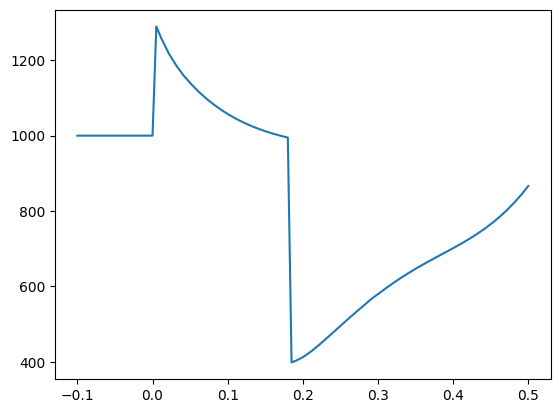

In [13]:
import matplotlib.pyplot as plt
p_g_01 = pfri.get_simulation_results_from_dataframe(
    df_sim_res, 
    g_01, # accepts PF objects (or also their path)
    RMS_bal.ElmSym.s_P1.value)
plt.plot(p_g_01)

p_g_01.head(2)

Let's look a more complicated example where you want to examine the active and reactive power of the synchronous machines `G 01` and `G 02`.  

In [14]:
# SM objects
sm_objs = [pfri.get_unique_obj(r"Network Model\Network Data\Grid\G 01"),
           pfri.get_unique_obj(r"Network Model\Network Data\Grid\G 02")]

# Results variables
sm_res_var = [RMS_bal.ElmSym.s_P1.value, RMS_bal.ElmSym.s_Q1.value]

pfri.clear_elmres()
pfri.add_results_variable(sm_objs, sm_res_var)
pfdi = powfacpy.PFDynSimInterface(app)
pfdi.initialize_and_run_sim()

We want to add a legend to the plots. As the default variable and object names might not be very descriptive, *powfacpy* allows to define aliases, e.g. to be used later for labels in plots:

In [15]:
pfri.variable_aliases = {
  RMS_bal.ElmSym.s_P1.value: "Active Power", 
  RMS_bal.ElmSym.s_Q1.value: "Reactive Power",
} # note that RMS_bal.ElmSym.s_P1.value gives 's:P1'

pfri.obj_aliases = {
  "G 01": "Synch. Maschine 1 (large)",
  "G 02": "Synch. Maschine 2",
}

Let's see how the `variable_aliases` dictionary can then be used when plotting active and reactive power of `G 01` using `replace_variable_aliases`:

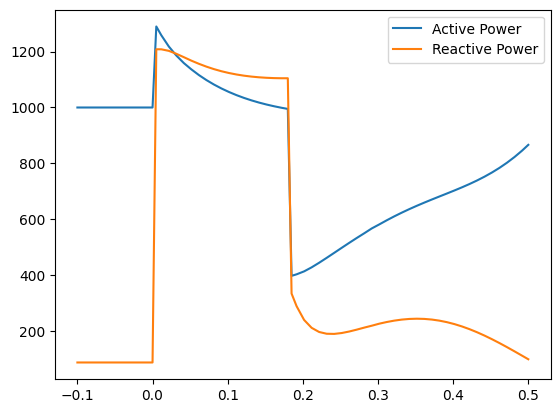

In [16]:
for var in sm_res_var:
  res = pfri.get_simulation_results_from_dataframe(
    df_sim_res, 
    sm_objs[0], # object or its path
    var)
  label = pfri.replace_variable_aliases(var)
  plt.plot(res, label=label)
plt.legend()

Instead of `s:P1` or `s:Q1`, the replacements defined in the dictionaries above are used for the labels.

Or in a similar fashion, using also the `object_aliases` to plot the reactive power of both machines:

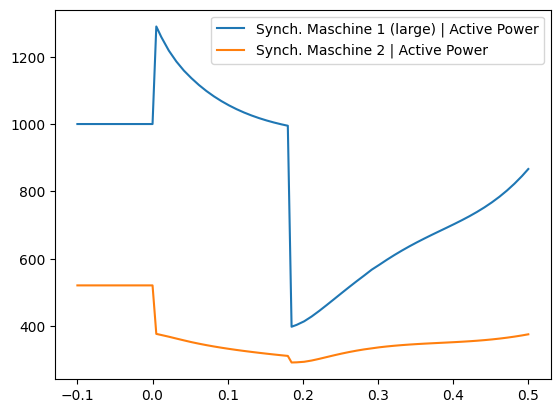

In [17]:
var = RMS_bal.ElmSym.s_P1.value
for sm in sm_objs:
  res = pfri.get_simulation_results_from_dataframe(
    df_sim_res, 
    sm, 
    var)
  label = pfri.replace_object_aliases(sm.loc_name) + " | " + pfri.replace_variable_aliases(var)
  plt.plot(res, label=label)
plt.legend()  

Hence, the dictionaries are a clean option to define aliases and reuse them anywhere in your code.


By default, `export_to_pandas` exports all monitored variables of the first `ElmRes` object found in the active study case. Alternatively, network elements and the respective variables as well as results objects (`ElmRes`) can be specified as lists:

In [18]:
elements =   [g_01, g_01]
variables = [RMS_bal.ElmSym.s_P1.value, RMS_bal.ElmSym.s_Q1.value]
elmres_list = [pfri.get_results_obj_from_initial_conditions_calc()]*len(variables)

df_sim_res = pfri.export_to_pandas(list_of_results_objs=elmres_list, 
                           elements=elements, 
                           variables=variables)
df_sim_res.head(2)

,G 01\s:P1,G 01\s:Q1
time,,
-0.10,1000.0,88.281415
-0.09,1000.0,88.281415


## Export to CSV Format
We can also export simulation results from PowerFactory to a csv file. The syntax is very simlar to the export to pandas:

In [19]:
pfri.export_to_csv()

'd:\\User\\seberlein\\FraunhIEE-UniKassel-PowSysStability\\powfacpy\\tutorials\\results.csv'

This exports all variables from the first result object (`ElmRes`) found in the active study case to the directory from where the script is run. You can also specifiy a directory, a file name (default is "results") and lists for grid objects, variables and results objects (similar to the method `export_to_pandas`). 



In [23]:
elements =   [g_01, g_01]
variables = [RMS_bal.ElmSym.s_P1.value, RMS_bal.ElmSym.s_Q1.value]
elmres_list = [pfri.get_results_obj_from_initial_conditions_calc()]*len(variables)

pfri.export_to_csv(
  file_name="Active power of Synchronous Machine 01",
  list_of_results_objs=elmres_list, 
  elements=elements, 
  variables=variables)

'd:\\User\\seberlein\\FraunhIEE-UniKassel-PowSysStability\\powfacpy\\tutorials\\Active power of Synchronous Machine 01.csv'

The formatting of the exported csv file is as follows: the first line (header) specifies the path of the variables (object path + variable name), e.g. "Network Model\Network Data\test_plot_interface\Grid 1\WECC WT Control System Type 4A\REEC_A Electrical Control Model\s:Iqcmd" in all columns except for the first one, which is "Time". The remaining rows contain the values of the variables.

The static method `plot_from_csv` is used to plot from files of this format:

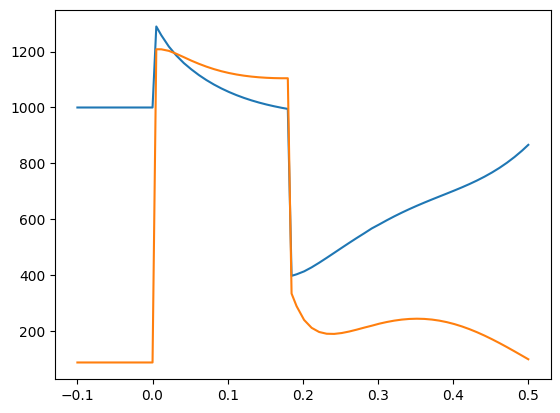

In [24]:
plot = powfacpy.PFPlotInterface.plot_from_csv(
    "Active power of Synchronous Machine 01.csv", 
    "G 01\s:P1")  
plot = powfacpy.PFPlotInterface.plot_from_csv(
    "Active power of Synchronous Machine 01.csv", 
    "G 01\s:Q1")

*Pyplot* is used by default, but you can specify a different plot interface using the optional argument `plot_interface`.